#### NCSU GIS 714: Geospatial Computation and Simulations

## Surface Water Simulation: Introduction to Surface Water Simulation

Contents:
* Compare flow accumulation derived by different algorithms
* Create a map of flooded area
* Estimate inundation extent using HAND methodology

Additional Resources:
    
* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
    
* [GRASS book](http://www.grassbook.org/)
* For more practice in watershed analysis see
[Flow and watershed analysis in GIS582](http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/hydrology.html)

Tip: While executing this notebook, you can launch the GUI in the command line interface with `g.gui`. As you create rasters here, they will appear in the GUI where you can render them, view other layers, etc.

#### Start GRASS GIS

In [1]:
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
# FOR WINDOWS:
grass_call = "grass80"
# FOR MAC/LINUX
#grass_call = "grass"
sys.path.append(
    subprocess.check_output([grass_call, "--config", "python_path"], text=True, shell=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../../../../grassdata", "nc_spm_08_grass7", "PERMANENT")

# Make a new mapset for this assignment
gs.run_command("g.mapset", mapset="HW3_water_simulation", location="nc_spm_08_grass7", flags="c")

### Compare flow accumulation derived by different algorithms

First, we'll set region to the high resolution study area and render it.

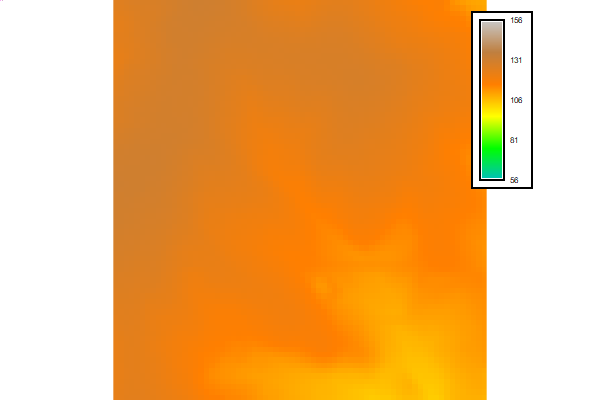

In [2]:
# Set region to the high resolution study area
gs.run_command("g.region", region="rural_1m")

# Create GrassRenderer instance
gs.run_command("r.colors", map="elevation", co="elevation")
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="elevation")
img.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()

Then, we run least cost path flow routing with single flow direction (SFD, D8).

In [3]:
gs.run_command("r.watershed", elevation="elev_lid792_1m", threshold=5000, accumulation="accum_mfd5K", drainage="draindir_5K", basin="basin_mfd5K", flags="a")

#### *Question 1*
    
Repeat the least cost path flow routing above but with multiple flow direction (MFD). (hint: refer to the GRASS manual)

In [ ]:
### Your Answer Here

### Answer:
!r.watershed -as elevation=elev_lid792_1m threshold=5000 accumulation=accum_sfd5K drainage=draindir_sfd5K basin=basin_sfd5K

#### *Question 2*
    
An alternative to MFD and SFD is vector-based routing (D-inf). In GRASS, this is implemented with `r.flow`. Compute flowlines, flow length and flow accumulation with `r.flow`. Then extract the streams from each of the three flow accumulation rasters by setting cells >100 to 1 and <100 to null(). Thin the result to one-cell width and convert to a vector so that the streams are represented by lines. Visually compare the resulting stream paths, including the official Wake County streams found in `PERMANENT`.

In [ ]:
### Your Answer Here


# Answer:
!r.flow elevation=elev_lid792_1m flowline=flowlines flowlength=flowlg_1m flowaccumulation=flowacc_1m

!r.mapcalc "streams_mfd = if(abs(accum_mfd5K) > 100, 1, null())"
!r.thin streams_mfd output=streams_mfd_t
!r.to.vect -s streams_mfd_t out=streams_mfd_t type=line

#### *Question 3*

Compare the values of flowaccumulation from all your runs, including the ones from data simulation 
assignment, in outlet with coordinates 638845.52,220085.26. (hint, use r.what). Discuss the result.

### Create a map of flooded area
Create a map of flooded area for a given water level and a seed point:

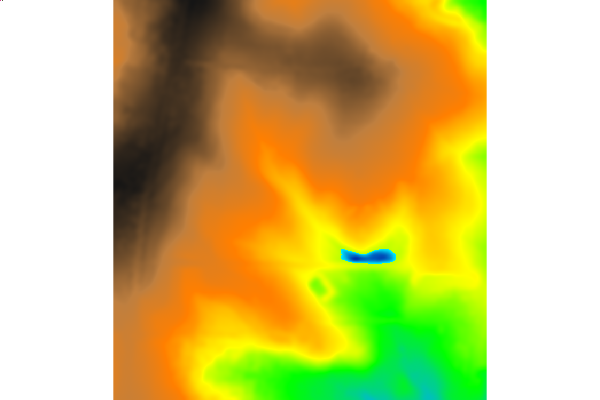

In [4]:
gs.run_command("r.lake", elevation="elev_lid792_1m", water_level=113.5, lake="flood1", coordinates="638728,220278")

# See results
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="elev_lid792_1m")
img.d_rast(map="flood1")
# Display map
img.show()

#### *Question 4*

Increase water level to 113.7 m and 114.0 m and create flooded area maps at these two levels.

### Hydrology: Estimating inundation extent using HAND methodology

We will use r.stream.distance and r.lake.series are addons and we need to install them first:

In [ ]:
#!g.extension r.stream.distance
#!g.extension r.lake.series

We will estimate inundation extent using Height Above Nearest Drainage methodology (A.D. Nobre, 2011). We will compute HAND terrain model representing the differences in elevation between each grid cell and the elevations of the flowpath-connected downslope grid cell where the flow enters the channel.

First we compute the flow accumulation, drainage and streams (with threshold value of 100000). We convert the streams to vector for better visualization.

In [5]:
gs.run_command("g.region", raster="elevation")
gs.run_command("r.watershed", elevation="elevation", accumulation="flowacc", drainage="drainage", stream="streams", threshold=100000)
gs.run_command("r.to.vect", input="streams", output="streams", type="line")

Now we use r.stream.distance with output parameter difference to compute new raster where each cell is the elevation difference between the cell and the the cell on the stream where the cell drains.

In [6]:
gs.run_command("r.stream.distance", stream_rast="streams", direction="drainage", elevation="elevation", method="downstream", difference="above_stream")

Before we compute the inundation, we will look at how r.lake works. We compute a lake from specified coordinate and water level:

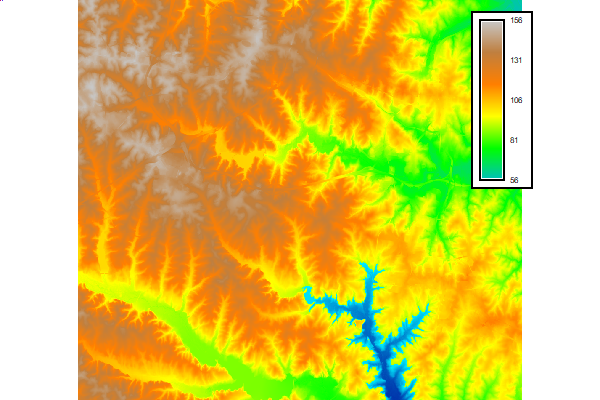

In [7]:
gs.run_command("r.lake", elevation="elevation", water_level=90, lake="lake", coordinates="637877,218475")

# See results
img = gj.GrassRenderer(use_region=True)
img.d_rast(map="elevation")
img.d_rast(map="lake")
img.d_legend(raster="elevation", at=(55, 95, 80, 84), flags="b")
# Display map
img.show()

Now instead of elevation raster we use the HAND raster to simulate 5-meter inundation and as the seed we specify the entire stream.

In [8]:
gs.run_command("r.lake", elevation="above_stream", water_level=5, lake="flood", seed="streams")

With addon r.lake.series we can create a series of inundation maps with rising water levels:

In [9]:
gs.run_command("r.lake.series", elevation="above_stream", start_water_level=0, end_water_level=5, water_level_step=0.5, 
               output="inundation", seed_raster="streams")

r.lake.series creates a space-time dataset. We can use temporal modules to further work with the data. For example, we could further compute the volume and extent of flood water using t.rast.univar:

In [ ]:
print(gs.read_command("t.rast.univar", input="inundation", separator="comma"))

Now we will export the results from r.lake.series so that we can display the animated series of inundation maps with rising water levels in MapBox GL. To do this we must export each raster as a png and get the bounding box of the computational region in WGS84. First download r.out.leaflet from [https://github.com/ncsu-geoforall-lab/](https://github.com/ncsu-geoforall-lab/) or clone the plugin using git.

In [ ]:
!git clone https://github.com/ncsu-geoforall-lab/grass-web-publishing.git

Next, find r.out.leaflet.py inside of the grass-web-publishing directory you just downloaded. Now in the GRASS terminal we will run the r.out.leaflet.py python script.

In [ ]:
!mkdir images
!python3 grass-web-publishing/r.out.leaflet/r.out.leaflet.py raster="inundation_0.0,inundation_0.5,inundation_1.0,inundation_1.5,inundation_2.0,inundation_2.5,inundation_3.0,inundation_3.5,inundation_4.0,inundation_4.5,inundation_5.0" output="./images"

You will now see a few new files in the images directory

* data_file.csv    
*  data_file.js
* New pngs


To add the newly output pngs to a web map continue by following the instructions found in the next tutorial here:

[https://github.com/ncsu-geoforall-lab/grass-mapbox-tutorial](https://github.com/ncsu-geoforall-lab/grass-mapbox-tutorial)

### Additional Information
* [Website](https://github.com/ncsu-geoforall-lab/geospatial-simulations-course)
    
* [Computing Help](https://help.ncsu.edu/)
    
* [GIST Home](https://geospatial.ncsu.edu/)
    
* [Disclaimer](https://www.ncsu.edu/policies/prr-disclaimer.php)
    
* [Accessibility](https://oit.ncsu.edu/itaccess)

* License: 2018 [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/)
  
* [NCSU GeoForAll Lab](https://geospatial.ncsu.edu/geoforall/)